<a href="https://colab.research.google.com/github/KenObata/Music4All_personal_project/blob/main/week14_EDA(undersample%3Dx8%2Calpha%3D0_02)_on_word2vec_then_SMOTE_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week14: This notebook does word matrix-> SMOTE -> undersample by EDA -> append to word vectors. -> using Word2Vec. Alpha=0.02, EDA size is by 8

Situation: English only (=multi-class).
Split: StratifiedKfold.
Reference: https://github.com/jasonwei20/eda_nlp


### Preprocess: import files

In [ ]:
#Check RAM size. If small, you can upgrade.
#you can enable a high-RAM runtime via Runtime > Change runtime type in the menu
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 3.4 MB/s 


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from collections import Counter

from skmultilearn.model_selection import IterativeStratification   
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix
plt.style.use('seaborn')

CSV_FOLDER = 'drive/MyDrive/music4all/'
LANG_DIR = 'drive/MyDrive/music4all/split-language_only-artist_grouped'
SPLIT_DIR = 'drive/MyDrive/music4all/split-all_labels'
FIG_DIR = 'drive/MyDrive/music4all/figures'

font = {'size': 22}

matplotlib.rc('font', **font)

scikit-multilearn has to be installed from pip
https://github.com/scikit-multilearn/scikit-multilearn/issues/142

In [ ]:
def write_txt(path, list_of_str):
    with open(path, 'w') as f:
        for value in list_of_str:
            f.write(value)
            f.write('\n')

In [ ]:
def analyze_genre_tag_df(df, target_column:int, top_n=100):
    """plot the occurrences of top_n items in the given df"""
    def get_counter(items: list):
        """items: list of list"""    
        items = [g.split(',') for g in items]
        items = [item for sublist in items for item in sublist]
        items = Counter(items)    
        return items
    
    def plot_freqs(counter: Counter, top_n, title=''):
        most_common = counter.most_common(top_n)
        names, counts = list(zip(*most_common))

        xs = np.arange(len(names))
        plt.figure(figsize=(18, 7))
        plt.bar(xs, counts)
        plt.xticks(xs + 0.2, names, rotation=60, size=17, ha='right') 
        plt.title('Top-%d %s (out of %d in total)' % (top_n, title, len(counter)), size=20)
        plt.ylabel('occurrence', size=17)
        
    column_name = df.columns[target_column]
    labels = df[column_name].tolist()
    labels = get_counter(labels)
    
    print('Number of %s: %d' % (column_name, len(labels)))

    plot_freqs(labels, top_n=top_n, title=column_name)
    return labels
    
def analyze_genre_tag_csv(csv_path, top_n):
    """wrapper of analyze_genre_tag_df"""
    basename = os.path.basename(csv_path)
    df = pd.read_csv(os.path.join(CSV_FOLDER, csv_path), header=0, sep='	')
    df.head()
    return analyze_genre_tag_df(df, target_column =1, top_n=top_n)

### Data preparation

id_genres.csv

Number of genres: 853


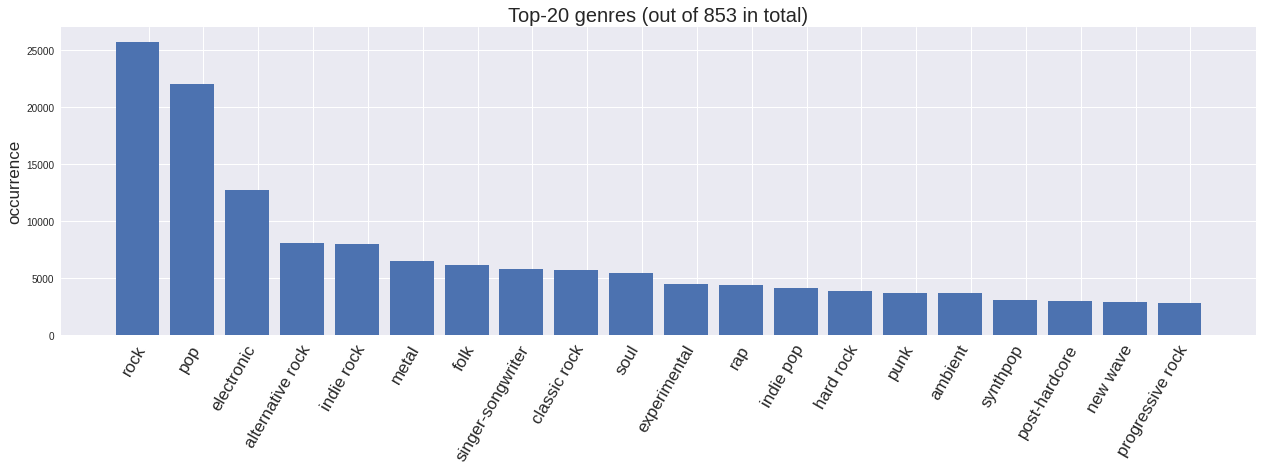

In [ ]:
genre_counter = analyze_genre_tag_csv('id_genres.csv',top_n=20)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'occurrence-genre.png'))

In [ ]:
genre_counter = sorted(genre_counter.items(), key=lambda item: item[1], reverse = True)
genre_counter_top = genre_counter[:15]

In [ ]:
genre_counter_top_list = [genre for genre, count in genre_counter_top ]
genre_counter_top_list

['rock',
 'pop',
 'electronic',
 'alternative rock',
 'indie rock',
 'metal',
 'folk',
 'singer-songwriter',
 'classic rock',
 'soul',
 'experimental',
 'rap',
 'indie pop',
 'hard rock',
 'punk']

In [ ]:
#filter genre dataset as top15 genre only and later inner join with English.
df_genres = pd.read_csv(os.path.join(CSV_FOLDER, 'id_genres.csv'), header=0, sep='	')
df_genre_top20 = df_genres[df_genres['genres'].isin(genre_counter_top_list)]
df_genre_top20

,id,genres
0,0009fFIM1eYThaPg,pop
11,00P2bHdWFkghmDqz,soul
14,00XWljDxNBgBKEEA,pop
16,00b6fV3nx5z2b8Ls,pop
26,013QDoTqbexEwkHr,pop
...,...,...
109253,zzgS4ZqyswamEWNj,pop
109254,zziALZG1JQ2uUjcy,metal
109262,zzx8CWdM7qkxKQpC,indie rock
109265,zzz0n04uuTUA7fNh,pop


Dataframe narrowed down to 18603 rows. Notice that rank20 has only 169 data. So depending on the result we might need to narrow down to top10 genre?

### Filter only English
 Note that this split have overlapping artist in both sets. See artist-grouped-stratified-split for an improved version.

In [ ]:
en_lang =['en']
df_lang = pd.read_csv(os.path.join(CSV_FOLDER, 'id_lang.csv'), header=0, sep='	')
df_lang_en=df_lang[ df_lang['lang'].isin(en_lang) ]
df_lang_en

,id,lang
0,0009fFIM1eYThaPg,en
1,0010xmHR6UICBOYT,en
2,002Jyd0vN4HyCpqL,en
3,006TYKNjNxWjfKjy,en
4,007LIJOPQ4Sb98qV,en
...,...,...
109264,zzyyPUs7hC9Nz2e1,en
109265,zzz0n04uuTUA7fNh,en
109266,zzzj3LYaZtYtbzSr,en
109267,zzznMjZAKnJJXQSj,en


Originally it was 109269 rows, and now there are 84103 rows.

### Now, combine split by language and genre, so we classify each genre by language.

In [ ]:
# merge three dataframes into one
df_genre_by_lang = pd.concat([df_genre_top20['id'], df_genre_top20['genres'], df_lang_en['lang']]
                             , join='inner' ,axis=1)

#Do inner join
df_genre_by_lang


,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
11,00P2bHdWFkghmDqz,soul,en
16,00b6fV3nx5z2b8Ls,pop,en
26,013QDoTqbexEwkHr,pop,en
30,01EKNot8qVgZpKM7,rock,en
...,...,...,...
109253,zzgS4ZqyswamEWNj,pop,en
109254,zziALZG1JQ2uUjcy,metal,en
109262,zzx8CWdM7qkxKQpC,indie rock,en
109265,zzz0n04uuTUA7fNh,pop,en


ToDo: concatenate to the dataframe!

In [ ]:
final_genre_list = ["pop", "rock", "soul", "indie rock", "rap", "electronic", "folk", "singer-songwriter", "indie pop", "punk"]
#df_lang_en=df_lang[ df_lang['lang'].isin(en_lang) ]
df_genre_by_lang = df_genre_by_lang[ df_genre_by_lang["genres"].isin(final_genre_list) ]

After inner join, we can drop the bottom 5, alternative rock, hard rock, experimental, classic rock, and metal

Reindex

In [ ]:
df_genre_by_lang = df_genre_by_lang.reset_index(drop=True)
df_genre_by_lang

,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
1,00P2bHdWFkghmDqz,soul,en
2,00b6fV3nx5z2b8Ls,pop,en
3,013QDoTqbexEwkHr,pop,en
4,01EKNot8qVgZpKM7,rock,en
...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en
13536,zzgS4ZqyswamEWNj,pop,en
13537,zzx8CWdM7qkxKQpC,indie rock,en
13538,zzz0n04uuTUA7fNh,pop,en


### Get lyrics document as dataframe and append to X_train, X_test

In [ ]:
#create lyric column
df_genre_by_lang["lyric"] = ""
df_genre_by_lang

,id,genres,lang,lyric
0,0009fFIM1eYThaPg,pop,en,
1,00P2bHdWFkghmDqz,soul,en,
2,00b6fV3nx5z2b8Ls,pop,en,
3,013QDoTqbexEwkHr,pop,en,
4,01EKNot8qVgZpKM7,rock,en,
...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,
13536,zzgS4ZqyswamEWNj,pop,en,
13537,zzx8CWdM7qkxKQpC,indie rock,en,
13538,zzz0n04uuTUA7fNh,pop,en,


In [ ]:
#create temporary lyric folder on google collab
# do not read texts from google drive. it is slow.
ZIP_FILE ="drive/MyDrive/music4all/lyrics.zip"

!unzip drive/MyDrive/music4all/lyrics.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/__MACOSX/lyrics/._zdBYCzbDNIMuhViX.txt  
  inflating: /content/lyrics/ZDcFZHxn0FRohOUR.txt  
  inflating: /content/__MACOSX/lyrics/._ZDcFZHxn0FRohOUR.txt  
  inflating: /content/lyrics/zDCpdnbZRALOWkmA.txt  
  inflating: /content/__MACOSX/lyrics/._zDCpdnbZRALOWkmA.txt  
  inflating: /content/lyrics/zDDcHl1LkyDHddfD.txt  
  inflating: /content/__MACOSX/lyrics/._zDDcHl1LkyDHddfD.txt  
  inflating: /content/lyrics/ZdddE8E7syeob5Pm.txt  
  inflating: /content/__MACOSX/lyrics/._ZdddE8E7syeob5Pm.txt  
  inflating: /content/lyrics/ZdDk9TB3qpmNrFPl.txt  
  inflating: /content/__MACOSX/lyrics/._ZdDk9TB3qpmNrFPl.txt  
  inflating: /content/lyrics/zddluWGNq7d8zESq.txt  
  inflating: /content/__MACOSX/lyrics/._zddluWGNq7d8zESq.txt  
  inflating: /content/lyrics/ZDdsBqLxEJrjMseV.txt  
  inflating: /content/__MACOSX/lyrics/._ZDdsBqLxEJrjMseV.txt  
  inflating: /content/lyrics/zddXIHhmYcWpzZvS.txt  
  inflating: /content/__MACOS

### This time, apply no stemming and normilize words

In [ ]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

In [ ]:
text = "This is a test sentence. Yo, 123 today2022"
text= text.replace(',', '')
text = text.replace('.', '')
text_tokens = [stemmer.stem(word) for word in text.split(' ') ]
print(text_tokens)

#text_tokens_alphabet = []
#for word in text.split(' '):
#  temp_word = stemmer.stem(word)
#  print("temp:", temp_word)
#  if temp_word.isalpha():
#    text_tokens_alphabet.append(temp_word)
text_tokens_alphabet = [stemmer.stem(word) for word in text.split(' ') if word.isalpha()]
print(text_tokens_alphabet)

['thi', 'is', 'a', 'test', 'sentenc', 'yo', '123', 'today2022']
['thi', 'is', 'a', 'test', 'sentenc', 'yo']


This study removes "," and "." to get only alphabets.

In [ ]:
#First 5000
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

df_genre_by_lang['number_of_line'] = 0
#df_genre_by_lang['text_split'] = []
for idx, row in df_genre_by_lang.loc[0:5000].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read()
      number_of_line = lyric_document.count('\n')

      lyric_document = lyric_document.replace('\n', ' ').replace(',', '').replace('.', '')
      lyric_document.lower()
      text_split = [word for word in lyric_document.split(' ') if word.isalpha() ]
      lyric_document=[' '.join(text_split) ]
      
      #df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "text_split"] =text_split
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "number_of_line"] = number_of_line
      #print(lyric_document)

  except Exception as e:
    print(e)


In [ ]:
#index 5001 ~ 7988
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

for idx, row in df_genre_by_lang.loc[5001:df_genre_by_lang.shape[0]].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read()
      number_of_line = lyric_document.count('\n')

      lyric_document = lyric_document.replace('\n', ' ').replace(',', '').replace('.', '')
      lyric_document.lower()
      text_split = [word for word in lyric_document.split(' ') if word.isalpha() ]
      lyric_document=[' '.join(text_split) ]

      #df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "text_split"] =text_split
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "number_of_line"] = number_of_line
      #print(lyric_document)

  except Exception as e:
    print(e)


In [ ]:
#Reindex again
df_genre_by_lang = df_genre_by_lang.reset_index(drop=True)

In [ ]:
df_genre_by_lang[0:df_genre_by_lang.shape[0]]

,id,genres,lang,lyric,number_of_line
0,0009fFIM1eYThaPg,pop,en,a sunny day so I got nowhere to hide Not a clo...,91
1,00P2bHdWFkghmDqz,soul,en,Tell me a tale that always was Sing me a song ...,36
2,00b6fV3nx5z2b8Ls,pop,en,A buh A buh You went to school to learn girl T...,74
3,013QDoTqbexEwkHr,pop,en,like a conversation where stops to breathe Is ...,20
4,01EKNot8qVgZpKM7,rock,en,Say the words I cannot say Say them on another...,31
...,...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,think what afraid of come in you know been mad...,18
13536,zzgS4ZqyswamEWNj,pop,en,Oh yeah yeah Last night I took a walk in the s...,75
13537,zzx8CWdM7qkxKQpC,indie rock,en,Innocence it come easy in a sense it never wil...,34
13538,zzz0n04uuTUA7fNh,pop,en,Girl you know how I feel I really Since you be...,65


In [ ]:
df_genre_by_lang.shape[0]

13540

### Apply Data Augmentation Preprocess

In [ ]:
int(1/4)+1

1

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Easy data augmentation techniques for text classification
# Jason Wei and Kai Zou

import random
from random import shuffle
random.seed(1)

#stop words list
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
			'ours', 'ourselves', 'you', 'your', 'yours', 
			'yourself', 'yourselves', 'he', 'him', 'his', 
			'himself', 'she', 'her', 'hers', 'herself', 
			'it', 'its', 'itself', 'they', 'them', 'their', 
			'theirs', 'themselves', 'what', 'which', 'who', 
			'whom', 'this', 'that', 'these', 'those', 'am', 
			'is', 'are', 'was', 'were', 'be', 'been', 'being', 
			'have', 'has', 'had', 'having', 'do', 'does', 'did',
			'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
			'because', 'as', 'until', 'while', 'of', 'at', 
			'by', 'for', 'with', 'about', 'against', 'between',
			'into', 'through', 'during', 'before', 'after', 
			'above', 'below', 'to', 'from', 'up', 'down', 'in',
			'out', 'on', 'off', 'over', 'under', 'again', 
			'further', 'then', 'once', 'here', 'there', 'when', 
			'where', 'why', 'how', 'all', 'any', 'both', 'each', 
			'few', 'more', 'most', 'other', 'some', 'such', 'no', 
			'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
			'very', 's', 't', 'can', 'will', 'just', 'don', 
			'should', 'now', '']

#cleaning up text
import re
def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################

#for the first time you use wordnet
#import nltk
#nltk.download('wordnet')
from nltk.corpus import wordnet 

def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words if word not in stop_words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			#print("replaced", random_word, "with", synonym)
			num_replaced += 1
		if num_replaced >= n: #only replace up to n words
			break

	#this is stupid but we need it, trust me
	sentence = ' '.join(new_words)
	new_words = sentence.split(' ')

	return new_words

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name().replace("_", " ").replace("-", " ").lower()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################

def random_deletion(words, p):

	#obviously, if there's only one word, don't delete it
	if len(words) == 1:
		return words

	#randomly delete words with probability p
	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	#if you end up deleting all words, just return a random word
	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################

def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)
	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0
	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words
	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################

def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	return new_words

def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		random_word = new_words[random.randint(0, len(new_words)-1)]
		synonyms = get_synonyms(random_word)
		counter += 1
		if counter >= 10:
			return
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)

########################################################################
# main data augmentation function
########################################################################

def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
	
	sentence = get_only_chars(sentence)
	words = sentence.split(' ')
	words = [word for word in words if word is not '']
	num_words = len(words)
	
	augmented_sentences = []
	num_new_per_technique = int(num_aug/4)+1#each technique at least increment one new song
	#print("new songs per song is:", num_new_per_technique)
	#sr
	if (alpha_sr > 0):
		n_sr = max(1, int(alpha_sr*num_words))
		for _ in range(num_new_per_technique):
			a_words = synonym_replacement(words, n_sr)
			augmented_sentences.append(' '.join(a_words))

	#ri
	if (alpha_ri > 0):
		n_ri = max(1, int(alpha_ri*num_words))
		for _ in range(num_new_per_technique):
			a_words = random_insertion(words, n_ri)
			augmented_sentences.append(' '.join(a_words))

	#rs
	if (alpha_rs > 0):
		n_rs = max(1, int(alpha_rs*num_words))
		for _ in range(num_new_per_technique):
			a_words = random_swap(words, n_rs)
			augmented_sentences.append(' '.join(a_words))

	#rd
	if (p_rd > 0):
		for _ in range(num_new_per_technique):
			a_words = random_deletion(words, p_rd)
			augmented_sentences.append(' '.join(a_words))

	augmented_sentences = [get_only_chars(sentence) for sentence in augmented_sentences]
	shuffle(augmented_sentences)

	#trim so that we have the desired number of augmented sentences
	if num_aug >= 1:
		augmented_sentences = augmented_sentences[:num_aug]
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	#append the original sentence
	augmented_sentences.append(sentence)

	return augmented_sentences

### Data Preparation(Kfold split)

Create dataframe for Gensim

In [ ]:
def load_data(df_col, y):
    texts, labels = [], []
    
    for line in df_col:
        # texts are already tokenized, just split on space
        # in a real use-case we would put more effort in preprocessing
        texts.append(line.split(' '))
    return pd.DataFrame({'texts': texts, 'labels': y})

In [ ]:
data = load_data(df_genre_by_lang["lyric"], df_genre_by_lang["genres"])

In [ ]:
data

,texts,labels
0,"[a, sunny, day, so, I, got, nowhere, to, hide,...",pop
1,"[Tell, me, a, tale, that, always, was, Sing, m...",soul
2,"[A, buh, A, buh, You, went, to, school, to, le...",pop
3,"[like, a, conversation, where, stops, to, brea...",pop
4,"[Say, the, words, I, cannot, say, Say, them, o...",rock
...,...,...
13535,"[think, what, afraid, of, come, in, you, know,...",indie rock
13536,"[Oh, yeah, yeah, Last, night, I, took, a, walk...",pop
13537,"[Innocence, it, come, easy, in, a, sense, it, ...",indie rock
13538,"[Girl, you, know, how, I, feel, I, really, Sin...",pop


In [ ]:
data['labels'] = data['labels'].astype('category')
label_mapping = data['labels'].cat.categories
data['labels'] = data['labels'].cat.codes
X = data['texts']
y = data['labels']

In [ ]:
type(X)

pandas.core.series.Series

In [ ]:
def StratifiedKFold_feature_and_df_glove(df, feature_list, y_name):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)  # 20% for test set 
  y = df[y_name]
  skf.get_n_splits(df[ feature_list ], y)

  splits = []

  for train_index, test_index in skf.split(df[ feature_list ], y):
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = df[ feature_list ].loc[train_index], df[ feature_list ].loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [ ]:
def StratifiedKFold_feature_and_df(X, y):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)  # 20% for test set 
  #y = df[y_name]
  skf.get_n_splits(X, y)#df[ feature_list ]

  splits = []

  for train_index, test_index in skf.split(X, y):#df[ feature_list ]
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X.loc[train_index], X.loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [ ]:
#feature_list = ["texts"] #this is BOW and TF-IDF
#splits = StratifiedKFold_feature_and_df( data, feature_list, 'labels')
splits = StratifiedKFold_feature_and_df( X,y)

TRAIN: [    0     1     3 ... 13537 13538 13539] TEST: [    2     4     5 ... 13526 13532 13535]
TRAIN: [    0     2     4 ... 13535 13536 13539] TEST: [    1     3     7 ... 13530 13537 13538]
TRAIN: [    0     1     2 ... 13537 13538 13539] TEST: [    8    14    22 ... 13521 13531 13536]
TRAIN: [    0     1     2 ... 13537 13538 13539] TEST: [   10    12    15 ... 13523 13525 13534]
TRAIN: [    1     2     3 ... 13536 13537 13538] TEST: [    0     6    11 ... 13529 13533 13539]


In [ ]:
split0=splits[0]
print(split0['X_train'].shape)
print(split0['y_train'].shape)
print(split0['X_test'].shape)
print(split0['y_test'].shape)

(10832,)
(10832,)
(2708,)
(2708,)


In [ ]:
split0['X_train']

0        [a, sunny, day, so, I, got, nowhere, to, hide,...
1        [Tell, me, a, tale, that, always, was, Sing, m...
3        [like, a, conversation, where, stops, to, brea...
6        [Locked, up, tight, Like, I, would, never, fee...
7        [sittin, in, the, crib, dreamin, about, leer, ...
                               ...                        
13534    [grandma, cookies, nigga, Shout, out, to, fron...
13536    [Oh, yeah, yeah, Last, night, I, took, a, walk...
13537    [Innocence, it, come, easy, in, a, sense, it, ...
13538    [Girl, you, know, how, I, feel, I, really, Sin...
13539    [wwI, oh, must, go, on, standing, You, break, ...
Name: texts, Length: 10832, dtype: object

In [ ]:
split0['y_train']

0        4
1        9
3        4
6        4
7        6
        ..
13534    6
13536    4
13537    3
13538    4
13539    8
Name: labels, Length: 10832, dtype: int8

### Augment equal ratio each song, try alpha=0.02 x8.

In [ ]:
genre_mapping = {}
for code,genre in enumerate(label_mapping):
  genre_mapping[genre] = code
  print(code, genre)

0 electronic
1 folk
2 indie pop
3 indie rock
4 pop
5 punk
6 rap
7 rock
8 singer-songwriter
9 soul


In [ ]:
genre_mapping

{'electronic': 0,
 'folk': 1,
 'indie pop': 2,
 'indie rock': 3,
 'pop': 4,
 'punk': 5,
 'rap': 6,
 'rock': 7,
 'singer-songwriter': 8,
 'soul': 9}

In [ ]:
df_y_train = pd.DataFrame(split0['y_train'])#, index = split0['y_train'].index, columns=["genres"])

counter = Counter(df_y_train['labels'])
counter

Counter({0: 763,
         1: 690,
         2: 537,
         3: 865,
         4: 4143,
         5: 306,
         6: 783,
         7: 1159,
         8: 556,
         9: 1030})

In [ ]:
MIN_COUNT = min(counter.values())
MIN_COUNT

306

In [ ]:
int(7/4) +1

2

In [ ]:
#We already know that:
#final_genre_list = ["pop", "rock", "soul", "indie rock", "rap", "electronic", "folk", "singer-songwriter", "indie pop", "punk"]
genre_needs_per_song = {}
for genre, count in counter.items():
  #each song is double
  genre_needs_per_song[genre] = 7#4 if you want to augment by 8, 1 if you want to augment 4
  #if genre != 4:
  #  genre_needs_per_song[genre] = int(round((genre_dict[4] - count)/count, 0))
genre_needs_per_song

{0: 7, 1: 7, 2: 7, 3: 7, 4: 7, 5: 7, 6: 7, 7: 7, 8: 7, 9: 7}

Be careful, we cannot run this function twice!!

WE ONLY AUGMENT TRAINING DATA

In [ ]:
ORIGINAL_SIZE = split0['X_train'].tail(1).index.item()
ORIGINAL_SIZE

13539

In [ ]:
SCALER = 8

In [ ]:
X_train_eda = pd.Series(data = [])
y_train_eda = pd.Series(data = [])
augmented_count_by_genre = {0:MIN_COUNT*SCALER, 1:MIN_COUNT*SCALER, 2:MIN_COUNT*SCALER
                            , 3:MIN_COUNT*SCALER, 4:MIN_COUNT*SCALER, 5:MIN_COUNT*SCALER, 6:MIN_COUNT*SCALER, 
                            7:MIN_COUNT*SCALER,8:MIN_COUNT*SCALER,9:MIN_COUNT*SCALER}
augmented_count_by_genre

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


{0: 2448,
 1: 2448,
 2: 2448,
 3: 2448,
 4: 2448,
 5: 2448,
 6: 2448,
 7: 2448,
 8: 2448,
 9: 2448}

In [ ]:
for idx, token_list in split0['X_train'].loc[0:ORIGINAL_SIZE].items():
  genre_code = split0['y_train'].loc[idx]
  #genre = genre_mapping[genre_code]
  #if genre_code != 4:
  if genre_code!= 5 and \
    augmented_count_by_genre[genre_code] <= 0 or Counter(y_train_eda)[genre_code] >= MIN_COUNT*SCALER:
    continue

  else:
    needs = genre_needs_per_song[genre_code]
    original_df_row = df_genre_by_lang.loc[idx]
    new_songs= eda(original_df_row['lyric'], alpha_sr=0.02, alpha_ri=0.02, alpha_rs=0.02, p_rd=0.02, num_aug=needs)

    augmented_count_by_genre[genre_code]-=len(new_songs)

    for new_song in new_songs:
      new_song_tokens = new_song.split(' ')
      X_train_eda = X_train_eda.append( pd.Series([new_song_tokens]) , ignore_index=True)
      y_train_eda = y_train_eda.append( pd.Series( [genre_code] ) , ignore_index=True)
    
    #split0['X_train'] = split0['X_train'].append( pd.Series([new_song_tokens]) , ignore_index=True)
    #split0['y_train'] = split0['y_train'].append( pd.Series( [genre_code] ) , ignore_index=True)
      

In [ ]:
y_train_eda

0        4
1        4
2        4
3        4
4        4
        ..
12245    5
12246    5
12247    5
12248    5
12249    5
Length: 12250, dtype: int8

In [ ]:
X_train_eda

0        [a, sunny, day, so, i, got, nowhere, rainwater...
1        [a, sunny, day, so, i, father, nowhere, to, hi...
2        [a, gay, solar, day, so, i, got, nowhere, to, ...
3        [a, sunny, day, atomic, number, so, i, got, no...
4        [a, sunny, day, so, i, got, nowhere, to, hide,...
                               ...                        
24475    [been, trying, not, to, come, around, been, st...
24476    [been, trying, not, to, come, around, been, st...
24477    [been, trying, not, to, come, around, been, st...
24478    [been, trying, not, to, come, around, been, st...
24479    [been, trying, not, to, come, around, been, st...
Length: 24480, dtype: object

In [ ]:
Counter(y_train_eda)

Counter({0: 2448,
         1: 2448,
         2: 2448,
         3: 2448,
         4: 2448,
         5: 2448,
         6: 2448,
         7: 2448,
         8: 2448,
         9: 2448})

In [ ]:
Counter(split0['y_train'])

Counter({0: 763,
         1: 690,
         2: 537,
         3: 865,
         4: 4143,
         5: 306,
         6: 783,
         7: 1159,
         8: 556,
         9: 1030})

In [ ]:
Counter(split0['y_test'])

Counter({0: 190,
         1: 173,
         2: 135,
         3: 216,
         4: 1036,
         5: 76,
         6: 195,
         7: 290,
         8: 139,
         9: 258})

In [ ]:
split0['X_train']

0        [a, sunny, day, so, I, got, nowhere, to, hide,...
1        [Tell, me, a, tale, that, always, was, Sing, m...
3        [like, a, conversation, where, stops, to, brea...
6        [Locked, up, tight, Like, I, would, never, fee...
7        [sittin, in, the, crib, dreamin, about, leer, ...
                               ...                        
13534    [grandma, cookies, nigga, Shout, out, to, fron...
13536    [Oh, yeah, yeah, Last, night, I, took, a, walk...
13537    [Innocence, it, come, easy, in, a, sense, it, ...
13538    [Girl, you, know, how, I, feel, I, really, Sin...
13539    [wwI, oh, must, go, on, standing, You, break, ...
Name: texts, Length: 10832, dtype: object

### Gensim tutorial (count total vocab)
We start off by using the Gensim's implementation of the algorithm to provide a high-level intuition

In [ ]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
#%load_ext watermark
#%load_ext autoreload
#%autoreload 2
#%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
from time import time
from joblib import cpu_count
from collections import Counter
from gensim.models import Word2Vec
from sklearn.datasets import fetch_20newsgroups

#%watermark -a 'Ethen' -d -t -v -p numpy,scipy,pandas,sklearn,gensim

In [ ]:
#1.get tokens
#sentences = [doc.strip().split() for doc in df_genre_by_lang["lyric"]]
sentences = [ doc.strip().split() for doc in split0['X_train'] ]

workers = cpu_count()
word2vec = Word2Vec(sentences, workers=workers)

word_vectors = pd.DataFrame(word2vec.wv.vectors, index=word2vec.wv.index2word)

print('word vector dimension: ', word_vectors.shape)
word_vectors.head()

AttributeError: ignored

In [ ]:
print("sentences:", sentences[0])

Note to myself: how to change dimensionality and how much does it matter?
The lack of experiments for embedding size implies that the performance is not very sensitive to this parameter. But the number of dimensions can affect training time.

https://datascience.stackexchange.com/questions/51404/word2vec-how-to-choose-the-embedding-size-parameter


In [ ]:
word2vec.wv.most_similar(positive=['love'], topn=5)

There is a window size hyperparameter to the algorithm that quantifies the word "nearby". A typical window size might be 5, meaning 5 words behind and 5 words ahead (10 in total).

In [ ]:
word2vec.corpus_total_words

In [ ]:
vocab = word2vec.wv.vocab
index2word = word2vec.wv.index2word
print("vocaburary size:",len(vocab))
print(len(index2word))

In [ ]:
pd.set_option('display.max_rows', word_vectors.shape[1]+1)
word_vectors

### (Part1) Gensim Implementation

Parameter

sg=1 means to use skip-gram

min_count... is a threashhold that the algorithm requires a word need to appear at least x time ot be considered as part of skip-gram algorithm.

size... is the # of dimensions.

iterations ... ?


In [ ]:
!pip3 install transformers #==4.11.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.1 MB/s 
     |████████████████████████████████| 596 kB 70.2 MB/s 
     |████████████████████████████████| 6.6 MB 48.6 MB/s 
     |████████████████████████████████| 101 kB 11.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec


class GensimWord2VecVectorizer(BaseEstimator, TransformerMixin):
    """
    Word vectors are averaged across to create the document-level vectors/features.
    gensim's own gensim.sklearn_api.W2VTransformer doesn't support out of vocabulary words,
    hence we roll out our own.
    All the parameters are gensim.models.Word2Vec's parameters.
    https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
    """

    def __init__(self, size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None,
                 sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5,
                 ns_exponent=0.75, cbow_mean=1, hashfxn=hash, iter=5, null_word=0,
                 trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False,
                 callbacks=(), max_final_vocab=None):
        self.size = size
        self.alpha = alpha
        self.window = window
        self.min_count = min_count
        self.max_vocab_size = max_vocab_size
        self.sample = sample
        self.seed = seed
        self.workers = workers
        self.min_alpha = min_alpha
        self.sg = sg
        self.hs = hs
        self.negative = negative
        self.ns_exponent = ns_exponent
        self.cbow_mean = cbow_mean
        self.hashfxn = hashfxn
        self.iter = iter
        self.null_word = null_word
        self.trim_rule = trim_rule
        self.sorted_vocab = sorted_vocab
        self.batch_words = batch_words
        self.compute_loss = compute_loss
        self.callbacks = callbacks
        self.max_final_vocab = max_final_vocab

    def fit(self, X, y=None):
        self.model_ = Word2Vec(
            sentences=X, corpus_file=None,
            size=self.size, alpha=self.alpha, window=self.window, min_count=self.min_count,
            max_vocab_size=self.max_vocab_size, sample=self.sample, seed=self.seed,
            workers=self.workers, min_alpha=self.min_alpha, sg=self.sg, hs=self.hs,
            negative=self.negative, ns_exponent=self.ns_exponent, cbow_mean=self.cbow_mean,
            hashfxn=self.hashfxn, iter=self.iter, null_word=self.null_word,
            trim_rule=self.trim_rule, sorted_vocab=self.sorted_vocab, batch_words=self.batch_words,
            compute_loss=self.compute_loss, callbacks=self.callbacks,
            max_final_vocab=self.max_final_vocab)
        return self

    def transform(self, X):
        X_embeddings = np.array([self._get_embedding(words) for words in X])
        return X_embeddings

    def _get_embedding(self, words):
        valid_words = [word for word in words if word in self.model_.wv.vocab]
        if valid_words:
            embedding = np.zeros((len(valid_words), self.size), dtype=np.float32)
            for idx, word in enumerate(valid_words):
                embedding[idx] = self.model_.wv[word]

            return np.mean(embedding, axis=0)
        else:
            return np.zeros(self.size)

### Visualize samples for deep dive

In [ ]:
split0['X_train'][53964:53978]

53964    [innocence, it, come, easy, in, a, sense, it, ...
53965    [girl, you, know, coddle, how, i, feel, i, rea...
53966    [lady, friend, you, know, how, i, look, i, tru...
53967    [girl, you, know, how, i, feel, i, really, sin...
53968    [girl, you, know, first, how, i, feel, i, real...
53969    [girl, you, know, how, i, spirit, i, real, sin...
53970    [girl, you, how, i, feel, i, really, since, yo...
53971    [girl, you, know, how, i, feel, i, really, sin...
53972    [girl, you, know, i, feel, i, really, since, y...
53973    [girl, you, get, it, on, how, i, palpate, i, g...
53974    [girl, you, lie, with, how, i, palpate, i, rea...
53975    [girl, you, know, how, i, feel, i, really, sin...
53976    [girl, you, imperfections, how, speak, feel, u...
53977    [girl, you, know, all, i, you, i, really, sinc...
dtype: object

In [ ]:
split0['y_train'][53964:53978]

53964    5
53965    5
53966    5
53967    5
53968    5
53969    5
53970    5
53971    5
53972    5
53973    5
53974    5
53975    5
53976    5
53977    5
dtype: int8

In [ ]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [100]
n_estimators = [100]
#param_grid = dict(n_estimators=n_estimators)

for temp_size in SIZE_PARAMETER:
  for n_estimator in n_estimators:
    print("=======SIZE: ", temp_size ," n_estimator: ", n_estimator ,"========")
    #1.create model and clf
    gensim_word2vec_tr_temp2 = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)
    xgb_clf_SMOTE_temp2 = XGBClassifier(learning_rate=0.01, n_estimators=100, n_jobs=-1)

    #2.create word embedding and vector representation for each song
    gensim_word2vec_tr_temp2 = gensim_word2vec_tr_temp2.fit(split0['X_train'][53964:53978])
    X_embeddings_temp2 = gensim_word2vec_tr_temp2.transform(split0['X_train'][53964:53978])

=======SIZE:  100  n_estimator:  100 ========


In [ ]:
print(X_embeddings_temp2.shape, len(split0['y_train'][53964:53978]) )

(14, 100) 14


In [ ]:
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

df_word_vector2 = pd.DataFrame(X_embeddings_temp2)

In [ ]:
df_word_vector2['y'] = -1
for i, (idx, genre_code) in enumerate(split0['y_train'][53964:53978].items()):
  #df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] =
  df_word_vector2.loc[df_word_vector2.index == i, 'y'] = genre_code
#df_word_vector_origin['y'] = split0['y_train']

In [ ]:
df_word_vector2

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,y
0,-0.109938,0.128070,0.000026,-0.041524,0.019463,-0.069689,0.036723,0.150432,0.096423,0.051683,...,0.081604,0.069220,0.238075,0.093267,-0.188997,0.234951,0.062227,-0.151391,-0.073850,5
1,-0.120956,0.124696,-0.013318,-0.016583,0.004347,-0.088496,0.055014,0.151107,0.110501,0.044201,...,0.077086,0.081231,0.237948,0.091835,-0.202467,0.241014,0.067771,-0.166816,-0.090244,5
2,-0.132603,0.121595,-0.007589,-0.023357,0.006309,-0.056930,0.038231,0.168659,0.111507,0.038887,...,0.072594,0.092992,0.219459,0.083736,-0.225565,0.247906,0.065821,-0.180592,-0.098971,5
3,-0.117295,0.127629,-0.015603,-0.012792,0.004003,-0.091112,0.054614,0.151906,0.112038,0.045894,...,0.077424,0.080178,0.242864,0.091911,-0.202136,0.243947,0.064011,-0.168336,-0.091814,5
4,-0.121230,0.123116,-0.013207,-0.015405,0.004149,-0.089477,0.056926,0.149342,0.110869,0.043697,...,0.075681,0.080763,0.237858,0.091471,-0.200811,0.239305,0.068077,-0.165811,-0.088898,5
5,-0.115218,0.123858,-0.013120,-0.013452,0.004433,-0.089937,0.055757,0.148217,0.107294,0.044519,...,0.076035,0.076155,0.240184,0.090313,-0.194998,0.236983,0.066168,-0.162459,-0.084819,5
6,-0.120556,0.127451,-0.014406,-0.019906,0.005108,-0.091424,0.053173,0.149645,0.109827,0.045131,...,0.081283,0.080133,0.238141,0.093226,-0.202156,0.241362,0.073035,-0.168126,-0.090639,5
7,-0.119987,0.126510,-0.014377,-0.017851,0.004504,-0.093977,0.057008,0.148644,0.110077,0.042972,...,0.080541,0.080886,0.238997,0.094034,-0.198343,0.239236,0.072738,-0.165972,-0.088845,5
8,-0.115501,0.128505,-0.014039,-0.011705,0.004553,-0.087573,0.052421,0.155486,0.109124,0.045162,...,0.078314,0.078944,0.244407,0.091749,-0.202400,0.244361,0.063023,-0.167437,-0.089896,5
9,-0.131233,0.120609,-0.005375,-0.017174,0.006442,-0.054706,0.037670,0.173931,0.110935,0.044467,...,0.066875,0.087753,0.232150,0.081118,-0.229174,0.255467,0.056751,-0.181030,-0.096812,5


In [ ]:
feature_cols = [ num for num in range(0,100)]
pca2 = PCA(n_components=3)
pca_result2 = pca2.fit_transform(df_word_vector2[feature_cols].values)

df_word_vector2['pca-one'] = pca_result2[:,0]
df_word_vector2['pca-two'] = pca_result2[:,1] 
df_word_vector2['pca-three'] = pca_result2[:,2]

print('Explained variation per principal component: {}'.format(pca2.explained_variance_ratio_))

Explained variation per principal component: [0.57027394 0.30864903 0.07753664]


In [ ]:
number_of_y = len(set(df_word_vector2["y"]))
number_of_y

1

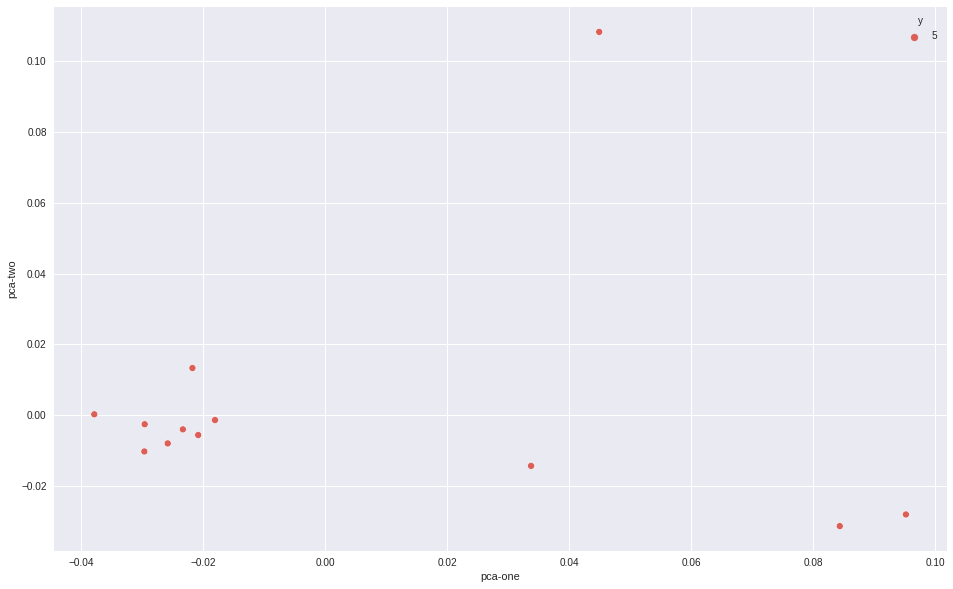

In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(df_word_vector2.shape[0])

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", number_of_y),
    data=df_word_vector2.loc[rndperm,:],
    legend="full",
    alpha=1
)

### Visualize word2vec made by EDA in 2D

In [ ]:
import plotly
import numpy as np
import plotly.graph_objs as go
from sklearn.decomposition import PCA

def display_pca_scatterplot_2D(model, user_input=None, words=None, label=None, color_map=None, topn=5, sample=10):

    if words == None:
        if sample > 0:
            #words = np.random.choice(list(model.vocab.keys()), sample)
            words = np.random.choice(model.wv.index2word, sample)
        else:
            words = [ word for word in model.wv.index2word ]
    
    word_vectors = np.array([model[w] for w in words])
    
    #three_dim = PCA(random_state=0).fit_transform(word_vectors)[:,:3]
    # For 2D, change the three_dim variable into something like two_dim like the following:
    two_dim = PCA(random_state=0).fit_transform(word_vectors)[:,:2]

    data = []
    count = 0
    
    for i in range (len(user_input)):

                trace = go.Scatter(
                    x = two_dim[count:count+topn,0], 
                    y = two_dim[count:count+topn,1],  
                    #z = three_dim[count:count+topn,2],
                    text = words[count:count+topn],
                    name = user_input[i],
                    textposition = "top center",
                    textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 0.8,
                        'color': 2
                    }
       
                )
                
                # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable. Also, instead of using
                # variable three_dim, use the variable that we have declared earlier (e.g two_dim)
            
                data.append(trace)
                count = count+topn

    trace_input = go.Scatter(
                    x = two_dim[count:,0], 
                    y = two_dim[count:,1],  
                    #z = two_dim[count:,2],
                    text = words[count:],
                    name = 'input words',
                    textposition = "top center",
                    textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 1,
                        'color': 'black'
                    }
                    )

    # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable.  Also, instead of using
    # variable three_dim, use the variable that we have declared earlier (e.g two_dim)
            
    data.append(trace_input)
    
# Configure the layout

    layout = go.Layout(
        margin = {'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
        legend=dict(
        x=1,
        y=0.5,
        font=dict(
            family="Courier New",
            size=25,
            color="black"
        )),
        font = dict(
            family = " Courier New ",
            size = 15),
        autosize = False,
        width = 1000,
        height = 1000
        )


    plot_figure = go.Figure(data = data, layout = layout)
    plot_figure.show()

In [ ]:
#gensim_word2vec_tr_temp.model_.vocabulary
#gensim_word2vec_tr_temp.model_.wv.index2word
gensim_word2vec_tr_temp.model_['you']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 0.17213604,  0.1417761 ,  0.29048097, -0.02521421,  0.09040602,
        0.09541448, -0.01730721,  0.28027448,  0.1994231 , -0.04086182,
       -0.22564037, -0.00644038, -0.10359371,  0.26324925,  0.01137366,
       -0.01231732,  0.06843819,  0.12087193,  0.11800954, -0.00109821,
       -0.2993008 , -0.12486805, -0.06537191,  0.11754801, -0.35321894,
       -0.29461768,  0.11721556, -0.08256865, -0.11422376,  0.11783767,
        0.04700575,  0.24017951,  0.12355034,  0.21579848, -0.07218829,
       -0.10657607, -0.05170955, -0.17658156, -0.36465836, -0.02715311,
        0.11507592, -0.18678167, -0.11054409, -0.08173051,  0.00507572,
       -0.07734002, -0.17946576, -0.01150256, -0.05092629, -0.09468751,
        0.21542606,  0.01337016,  0.19882739, -0.3424764 , -0.01442364,
        0.03434582, -0.15541665,  0.0911254 ,  0.27268678, -0.48929143,
        0.27204457, -0.19437191, -0.01013807, -0.23747884, -0.07302929,
        0.01803263,  0.0171726 , -0.26883495, -0.02916776, -0.10

In [ ]:
display_pca_scatterplot_2D(gensim_word2vec_tr_temp.model_, user_input=split0['X_train'][53992]
                           , words=None, label=None, color_map=None,sample=1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [ ]:
split0['X_train'][53992]

['wwi',
 'oh',
 'must',
 'go',
 'on',
 'stand',
 'you',
 'break',
 'that',
 'which',
 'your',
 'i',
 'oh',
 'must',
 'go',
 'on',
 'stand',
 'not',
 'my',
 'own',
 'not',
 'my',
 'choic',
 'be',
 'afraid',
 'of',
 'the',
 'lame',
 'inherit',
 'your',
 'leg',
 'be',
 'afraid',
 'of',
 'the',
 'old',
 'inherit',
 'your',
 'soul',
 'be',
 'afraid',
 'of',
 'the',
 'cold',
 'inherit',
 'your',
 'blood',
 'apr',
 'moi',
 'le',
 'delug',
 'after',
 'me',
 'come',
 'the',
 'flood',
 'i',
 'oh',
 'must',
 'go',
 'on',
 'stand',
 'you',
 'break',
 'that',
 'which',
 'your',
 'your',
 'i',
 'oh',
 'must',
 'go',
 'on',
 'stand',
 'not',
 'my',
 'own',
 'not',
 'my',
 'choic',
 'be',
 'afraid',
 'of',
 'the',
 'lame',
 'inherit',
 'your',
 'leg',
 'be',
 'afraid',
 'of',
 'the',
 'old',
 'inherit',
 'your',
 'soul',
 'be',
 'afraid',
 'of',
 'the',
 'cold',
 'inherit',
 'your',
 'blood',
 'apr',
 'moi',
 'le',
 'delug',
 'after',
 'me',
 'come',
 'the',
 'flood',
 'be',
 'afraid',
 'of',
 'the',


### Apply SMOTE then Gensim with XGB parameter tuning 

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [100, 200, 300, 400] 
n_estimators = [100, 200,300,400]

for temp_size in SIZE_PARAMETER:
  for n_estimator in n_estimators:
    print("=======SIZE: ", temp_size ," n_estimator: ", n_estimator ,"========")
    #1.create model and clf
    gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)
    xgb_clf_SMOTE_temp = XGBClassifier(learning_rate=0.01, n_estimators=n_estimator, n_jobs=-1)

    #2.create word embedding and vector representation for each song
    gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])
    X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])

    #3.SMOTE on train
    X_resampled_temp, y_resampled_temp = SMOTE().fit_resample(X_embeddings_temp, split0['y_train'])
    
    #3-1. undersample by eda
    X_embeddings_minor = gensim_word2vec_tr_temp.transform( X_train_eda )
    X_resampled_minor, y_resampled_minor = SMOTE().fit_resample(X_embeddings_minor, y_train_eda)

    #3-2. concatenate
    #stop = 0
    for row, genre_code in zip(X_resampled_minor, y_resampled_minor):
      X_resampled_temp = np.vstack((X_resampled_temp, row))
      y_resampled_temp = y_resampled_temp.append( pd.Series( [genre_code] ) , ignore_index=True) 

    #4.train
    xgb_clf_SMOTE_temp.fit(X_resampled_temp, y_resampled_temp)

    #5.Create test embedding and then predict
    #Note: this is because test embedding shape changes for each loop
    X_test_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_test'])
    y_test_pred_SMOTE_temp = xgb_clf_SMOTE_temp.predict(X_test_embeddings_temp)
    print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) )
    print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))

=======SIZE:  100  n_estimator:  100 ========
              precision    recall  f1-score   support

           0       0.13      0.08      0.10       190
           1       0.19      0.33      0.24       173
           2       0.15      0.15      0.15       135
           3       0.18      0.12      0.15       216
           4       0.52      0.17      0.25      1036
           5       0.11      0.37      0.17        76
           6       0.50      0.74      0.60       195
           7       0.14      0.05      0.08       290
           8       0.13      0.26      0.17       139
           9       0.16      0.45      0.23       258

    accuracy                           0.23      2708
   macro avg       0.22      0.27      0.21      2708
weighted avg       0.32      0.23      0.23      2708

0.2725880018076304
=======SIZE:  100  n_estimator:  200 ========
              precision    recall  f1-score   support

           0       0.13      0.15      0.14       190
           1       0.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [100, 200, 300, 400] 
n_estimators = [100, 200,300,400]

for temp_size in SIZE_PARAMETER:
  for n_estimator in n_estimators:
    print("=======SIZE: ", temp_size ," n_estimator: ", n_estimator ,"========")
    #1.create model and clf
    gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)
    xgb_clf_SMOTE_temp = XGBClassifier(learning_rate=0.01, n_estimators=n_estimator, n_jobs=-1)

    #2.create word embedding and vector representation for each song
    gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])
    X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])

    #3.SMOTE on train
    X_resampled_temp, y_resampled_temp = SMOTE().fit_resample(X_embeddings_temp, split0['y_train'])
    
    #3-1. undersample by eda
    X_embeddings_minor = gensim_word2vec_tr_temp.transform( X_train_eda )
    X_resampled_minor, y_resampled_minor = SMOTE().fit_resample(X_embeddings_minor, y_train_eda)

    #3-2. concatenate
    #stop = 0
    for row, genre_code in zip(X_resampled_minor, y_resampled_minor):
      #if stop==0:
        #print(genre_code, row)
        
        #print("pd.Series( row ):", pd.Series( row ))
        #print("Before len(X_resampled_temp):", len(X_resampled_temp))
        #stop=1
      X_resampled_temp = np.vstack((X_resampled_temp, row))
      
      y_resampled_temp = y_resampled_temp.append( pd.Series( [genre_code] ) , ignore_index=True)
      #if stop==1:
      #  print("After len(X_resampled_temp):", len(X_resampled_temp))
      #  stop=2

    #4.train
    xgb_clf_SMOTE_temp.fit(X_resampled_temp, y_resampled_temp)

    #5.Create test embedding and then predict
    #Note: this is because test embedding shape changes for each loop
    X_test_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_test'])
    y_test_pred_SMOTE_temp = xgb_clf_SMOTE_temp.predict(X_test_embeddings_temp)
    print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) )
    print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))

=======SIZE:  100  n_estimator:  100 ========
              precision    recall  f1-score   support

           0       0.14      0.12      0.13       190
           1       0.13      0.34      0.19       173
           2       0.10      0.13      0.12       135
           3       0.14      0.08      0.10       216
           4       0.54      0.22      0.31      1036
           5       0.12      0.33      0.17        76
           6       0.49      0.78      0.60       195
           7       0.12      0.02      0.04       290
           8       0.10      0.10      0.10       139
           9       0.16      0.41      0.23       258

    accuracy                           0.24      2708
   macro avg       0.20      0.25      0.20      2708
weighted avg       0.31      0.24      0.23      2708

0.2534290532484214
=======SIZE:  100  n_estimator:  200 ========
              precision    recall  f1-score   support

           0       0.14      0.14      0.14       190
           1       0.

KeyboardInterrupt: ignored

In [ ]:
print(type(y_resampled_minor))
print(y_resampled_minor)
print(y_resampled_minor.shape)

print(type(y_resampled_temp))
print(y_resampled_temp)
print(y_resampled_temp.shape)



<class 'pandas.core.series.Series'>
0        4
1        4
2        9
3        9
4        4
        ..
12235    8
12236    8
12237    8
12238    8
12239    8
Length: 12240, dtype: int8
(12240,)
<class 'pandas.core.series.Series'>
0        4
1        9
2        4
3        4
4        6
        ..
41425    9
41426    9
41427    9
41428    9
41429    9
Name: labels, Length: 41430, dtype: int8
(41430,)


In [ ]:
print(type(row))
print(row)

<class 'numpy.ndarray'>
[ 0.14434925 -0.12066101  0.15019165 -0.19798993 -0.13952033 -0.24313691
 -0.42962193 -0.11274968 -0.2418613   0.02344092  0.01378212 -0.00576401
 -0.23211761  0.00971309 -0.0660435  -0.06791556  0.23342684  0.00963592
  0.02724931  0.13291197  0.05996989  0.08826891 -0.05280188  0.04336267
  0.2039027  -0.01010474 -0.05712588  0.08523614  0.02642251 -0.16160785
 -0.00434046  0.07536926  0.00165949  0.10559677 -0.01810145 -0.14475247
  0.24227461  0.07280745  0.05759922 -0.07763401 -0.16877516  0.2416377
  0.18365458 -0.02291071 -0.20262238  0.04002864  0.01602492  0.18438485
 -0.46975628 -0.15819271 -0.00864705  0.08313897 -0.02611782  0.08513532
 -0.34176493  0.05583869  0.21254817  0.07154029  0.03982189 -0.20177223
 -0.12444628 -0.3155326   0.11580899 -0.20311058 -0.04262313 -0.31160885
 -0.28639564 -0.30984727  0.09606648  0.02331468  0.06634243 -0.01156131
  0.51275355 -0.06610965  0.04260606 -0.1523011  -0.11463907 -0.17929792
  0.03790907 -0.0637395  -0.

In [ ]:
print(X_resampled_temp.shape)
X_resampled_temp = np.vstack((X_resampled_temp, row))
print(X_resampled_temp.shape)

(41430, 100)
(41431, 100)


In [ ]:
confusion_matrix(split0['y_test'], y_test_pred_SMOTE_temp)

array([[ 13,  11,   6,   7,  85,  20,  11,   5,  18,  14],
       [  4,  43,   9,   6,  27,  25,   2,  11,  26,  20],
       [  6,  17,  17,   7,  30,  18,   4,  12,  11,  13],
       [ 10,  25,  17,  14,  57,  27,   7,  16,  23,  20],
       [ 35,  73,  39,  18, 428,  48,  70,  46,  43, 236],
       [  3,   5,   7,   5,  23,  20,   7,   0,   1,   5],
       [  0,   5,   8,   3,  12,   7, 145,   4,   3,   8],
       [  8,  26,  17,  16,  86,  33,  17,  19,  27,  41],
       [  8,  26,   4,  11,  29,  12,   7,   6,  26,  10],
       [  7,  12,  18,   3,  88,  15,  16,   8,  12,  79]])

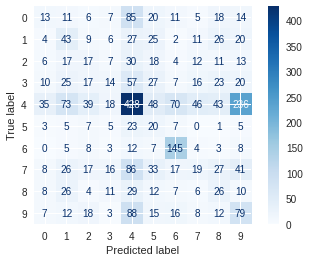

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(split0['y_test'], y_test_pred_SMOTE_temp
                                        , cmap=plt.cm.Blues)
#plt.figure(figsize=(10, 10))
plt.show()

Comment: to use SMOTE, we cannot use XGB Classifier as this is decision tree based algorithm.

gensim.fit(X,y) X is a list of token to feed into word embedding. But SMOTE is numeric. So I could not apply SMOTE. Also, if we apply SMOTE, this is not TF-IDF value anymore. What value do we SMOTE ? If we want numeric data, it is word representation, but it does not have y label anymore... So how do we SMOTE?


### Parameter tuning for SVM

In [ ]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [100, 200, 300, 400]

for temp_size in SIZE_PARAMETER:
  
  print("=======SIZE: ", temp_size  ,"========")
  #1.create model and clf
  gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)
  #xgb_clf = XGBClassifier(learning_rate=0.01, n_estimators=n_estimator, n_jobs=-1)
  clf_svm_EDA_temp = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

  w2v_xgb = Pipeline([
    ('w2v', gensim_word2vec_tr_temp), 
    ('svm', clf_svm_EDA_temp)
    ])
  
  #4.fit
  w2v_xgb.fit(split0['X_train'], split0['y_train'])
  

  #5.predict
  y_test_pred = w2v_xgb.predict(split0['X_test'])
  print(classification_report(split0['y_test'], y_test_pred) )
  print(balanced_accuracy_score(split0['y_test'], y_test_pred))

=======SIZE:  100 ========
              precision    recall  f1-score   support

           0       0.20      0.02      0.03       190
           1       0.07      0.08      0.07       173
           2       0.07      0.14      0.09       135
           3       0.10      0.13      0.12       216
           4       0.57      0.37      0.45      1036
           5       0.07      0.36      0.12        76
           6       0.80      0.55      0.65       195
           7       0.13      0.20      0.16       290
           8       0.14      0.04      0.06       139
           9       0.15      0.17      0.16       258

    accuracy                           0.26      2708
   macro avg       0.23      0.21      0.19      2708
weighted avg       0.34      0.26      0.28      2708

0.2053716332232812
=======SIZE:  200 ========
              precision    recall  f1-score   support

           0       0.11      0.04      0.06       190
           1       0.07      0.09      0.08       173
     

Since dimension 400 was missed. Just only do for 400 dim.

In [ ]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [400]

for temp_size in SIZE_PARAMETER:
  
  print("=======SIZE: ", temp_size  ,"========")
  #1.create model and clf
  gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)
  #xgb_clf = XGBClassifier(learning_rate=0.01, n_estimators=n_estimator, n_jobs=-1)
  clf_svm_EDA_temp = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

  w2v_xgb = Pipeline([
    ('w2v', gensim_word2vec_tr_temp), 
    ('svm', clf_svm_EDA_temp)
    ])
  
  #4.fit
  w2v_xgb.fit(split0['X_train'], split0['y_train'])
  

  #5.predict
  y_test_pred = w2v_xgb.predict(split0['X_test'])
  print(classification_report(split0['y_test'], y_test_pred) )
  print(balanced_accuracy_score(split0['y_test'], y_test_pred))

=======SIZE:  400 ========
              precision    recall  f1-score   support

           0       0.13      0.08      0.10       190
           1       0.11      0.17      0.13       173
           2       0.06      0.13      0.08       135
           3       0.14      0.19      0.16       216
           4       0.59      0.34      0.43      1036
           5       0.07      0.24      0.10        76
           6       0.66      0.57      0.61       195
           7       0.14      0.15      0.15       290
           8       0.11      0.09      0.10       139
           9       0.14      0.15      0.15       258

    accuracy                           0.25      2708
   macro avg       0.21      0.21      0.20      2708
weighted avg       0.34      0.25      0.28      2708

0.21098346476070895


### (Part3) GloVe pretrained model

In [ ]:
df_genre_by_lang

,id,genres,lang,lyric,number_of_line
0,0009fFIM1eYThaPg,pop,en,a sunni day so i got nowher to hide not a clou...,91
1,00P2bHdWFkghmDqz,soul,en,tell me a tale that alway wa sing me a song th...,36
2,00b6fV3nx5z2b8Ls,pop,en,a buh a buh you went to school to learn girl t...,74
3,013QDoTqbexEwkHr,pop,en,like a convers where stop to breath is it my i...,20
4,01EKNot8qVgZpKM7,rock,en,say the word i cannot say say them on anoth da...,31
...,...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,think what afraid of come in you know been mad...,18
13536,zzgS4ZqyswamEWNj,pop,en,oh yeah yeah last night i took a walk in the s...,75
13537,zzx8CWdM7qkxKQpC,indie rock,en,innoc it come easi in a sens it never will acc...,34
13538,zzz0n04uuTUA7fNh,pop,en,girl you know how i feel i realli sinc you bee...,65


In [ ]:
feature_list = ["lyric"] #this is BOW and TF-IDF
splits_glove = StratifiedKFold_feature_and_df_glove( df_genre_by_lang, feature_list, 'genres')

TRAIN: [    0     1     3 ... 13537 13538 13539] TEST: [    2     4     5 ... 13526 13532 13535]
TRAIN: [    0     2     4 ... 13535 13536 13539] TEST: [    1     3     7 ... 13530 13537 13538]
TRAIN: [    0     1     2 ... 13537 13538 13539] TEST: [    8    14    22 ... 13521 13531 13536]
TRAIN: [    0     1     2 ... 13537 13538 13539] TEST: [   10    12    15 ... 13523 13525 13534]
TRAIN: [    1     2     3 ... 13536 13537 13538] TEST: [    0     6    11 ... 13529 13533 13539]


In [ ]:
X_train = splits_glove[0]['X_train']
y_train = splits_glove[0]['y_train']
X_test = splits_glove[0]['X_test']
y_test = splits_glove[0]['y_test']
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10832, 1)
(10832,)
(2708, 1)
(2708,)


### Use Augmented data to do Glove pre-trained model

In [ ]:
#create contatenated lyric
for idx, token_list in split0['X_train'].items():
  lyric = ' '.join(token_list)
  split0['X_train'][idx] = lyric

In [ ]:
#create contatenated lyric
for idx, token_list in split0['X_test'].items():
    lyric = ' '.join(token_list)
    split0['X_test'][idx] = lyric

In [ ]:
split0['X_train']

0        a sunny day so I got nowhere to hide Not a clo...
1        Tell me a tale that always was Sing me a song ...
2        like a conversation where stops to breathe Is ...
3        Locked up tight Like I would never feel again ...
4        sittin in the crib dreamin about leer jets and...
                               ...                        
53988    wwi oh must go on standing you break that whic...
53989    wwi not must go oh standing you that break whi...
53990    wwi oh must go standing you break that which y...
53991    oh must go on you that yours i oh must go on s...
53992    wwi oh must go on standing you break that whic...
Length: 53993, dtype: object

In [ ]:
split0['y_train']

0        4
1        9
2        4
3        4
4        6
        ..
53988    5
53989    5
53990    5
53991    5
53992    5
Length: 53993, dtype: int8

In [ ]:
X_train = split0['X_train']
y_train = split0['y_train']
X_test = split0['X_test']
y_test = split0['y_test']
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(53993,)
(53993,)
(2708,)
(2708,)


In [ ]:
X_test

2        A buh A buh You went to school to learn girl T...
4        Say the words I cannot say Say them on another...
5        I was alone I was made of stone You took me ho...
9        Again the burden of losing rests upon my shoul...
20       only been three weeks And a bag of speed from ...
                               ...                        
13517    Like the legend of the Phoenix All ends with b...
13522    Mr Telephone man something wrong with my line ...
13526    can you imagine what it would be like we never...
13532    Love of my life hurt me broken my heart and no...
13535    think what afraid of come in you know been mad...
Name: texts, Length: 2708, dtype: object

In [ ]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [ ]:
y_train_to_index = {'electronic':0,'folk':1,
 'indie pop':2,
 'indie rock':3,
 'pop':4,
 'punk':5,
 'rap':6,
 'rock':7,
 'singer-songwriter':8,
 'soul':9}
y_train_to_index

{'electronic': 0,
 'folk': 1,
 'indie pop': 2,
 'indie rock': 3,
 'pop': 4,
 'punk': 5,
 'rap': 6,
 'rock': 7,
 'singer-songwriter': 8,
 'soul': 9}

In [ ]:
maxlen = 1744
#max_words = 10000
max_words=31458 #from the above

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
#maxlen = 100
training_samples = int(X_train.shape[0] * 0.8)#10000
validation_samples = X_train.shape[0]  - training_samples #832 #I try not to use validation_samples. songs are less than that.
#max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
#added
texts = X_train
labels = y_train
#for genre in y_train:
#  labels.append(y_train_to_index[genre])
#end of added 
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [ ]:
sequences

In [ ]:
y_train.shape

(53993,)

In [ ]:
labels.shape

(53993,)

In [ ]:
import tensorflow as tf
texts_test = X_test
labels_test = y_test
#for genre in y_test:
#  labels_test.append(y_train_to_index[genre])
#print(labels_test)

tokenizer_test = Tokenizer(num_words=max_words)
tokenizer_test.fit_on_texts(texts_test)
sequences_test = tokenizer_test.texts_to_sequences(texts_test)
data_test = pad_sequences(sequences_test, maxlen=maxlen) #, maxlen=maxlen

x_test = data_test
y_test = tf.keras.utils.to_categorical(labels_test, num_classes=10)
print(x_test)
print(y_test)
print(y_test.shape)

[[  0   0   0 ...  26   4 542]
 [  0   0   0 ... 232  21   1]
 [  0   0   0 ...   9  21   1]
 ...
 [  0   0   0 ...   1 112 132]
 [  0   0   0 ...  14   8  80]
 [  0   0   0 ...  15 158 591]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(2708, 10)


In [ ]:
#training_samples
x_test.shape

(2708, 1744)

In [ ]:
import tensorflow as tf
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
#convert to multi-class
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
#convert to multi-class
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)

print("x_train: " ,len(x_train) ,"x_val: ", len(x_val), "x_test: ", len(x_test))

Found 38883 unique tokens.
Shape of data tensor: (53993, 1744)
Shape of label tensor: (53993,)
x_train:  43194 x_val:  10799 x_test:  2708


In [ ]:
data

array([[   0,    0,    0, ...,    2,   17,    1],
       [   0,    0,    0, ...,  774,  774,  774],
       [   0,    0,    0, ...,   14,  201,   28],
       ...,
       [   0,    0,    0, ...,    1,   30,  166],
       [   0,    0,    0, ..., 1971,   16, 1549],
       [   0,    0,    0, ...,  186,   24,  139]], dtype=int32)

In [ ]:
print("x_train: " ,x_train.shape ,"x_val: ", x_val.shape, "x_test: ", x_test.shape)

x_train:  (43194, 1744) x_val:  (10799, 1744) x_test:  (2708, 1744)


In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_val

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

DOWNLOADING THE GLOVE WORD EMBEDDINGS
Go to https://nlp.stanford.edu/projects/glove, and download the precomputed
embeddings from 2014 English Wikipedia. It’s an 822 MB zip file called glove.6B.zip,
containing 100-dimensional embedding vectors for 400,000 words (or nonword
tokens). Unzip it.

In [ ]:
GLOVE_ZIP_FILE ="drive/MyDrive/music4all/glove.6B.zip"

!unzip drive/MyDrive/music4all/glove.6B.zip -d /content/

Archive:  drive/MyDrive/music4all/glove.6B.zip
  inflating: /content/glove.6B.50d.txt  
  inflating: /content/glove.6B.100d.txt  
  inflating: /content/glove.6B.200d.txt  
  inflating: /content/glove.6B.300d.txt  


In [ ]:
glove_dir = '/content'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Build Glove word embedding matrix

In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Words that are not found from lyrics are all 0.

Next define a model.

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

maxlen = 1744#10000

model_glove = Sequential()
model_glove.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model_glove.add(Flatten())
model_glove.add(Dense(32, activation='relu'))
model_glove.add(Dense(10, activation='softmax'))
model_glove.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1744, 100)         1000000   
                                                                 
 flatten (Flatten)           (None, 174400)            0         
                                                                 
 dense (Dense)               (None, 32)                5580832   
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 6,581,162
Trainable params: 6,581,162
Non-trainable params: 0
_________________________________________________________________


Load the embedded layer that I built in the model.

Right now, the model and the embedded layer is separated.



In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Train and evaluate

In [ ]:
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.compile(loss='categorical_crossentropy'
                  , optimizer='rmsprop'
    , metrics=['acc']
)
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=( x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Took 52 minutes.

In [ ]:
y_pred = model.predict(x_test, batch_size=32, verbose=1)

85/85 [==============================] - 1s 6ms/step


In [ ]:
y_pred.shape

(2708, 10)

In [ ]:
y_pred

array([[0.09786319, 0.10690574, 0.11112701, ..., 0.0908628 , 0.09764374,
        0.11083236],
       [0.09786319, 0.10690574, 0.11112701, ..., 0.0908628 , 0.09764374,
        0.11083236],
       [0.09786319, 0.10690574, 0.11112701, ..., 0.0908628 , 0.09764374,
        0.11083236],
       ...,
       [0.09786319, 0.10690574, 0.11112701, ..., 0.0908628 , 0.09764374,
        0.11083236],
       [0.09786319, 0.10690574, 0.11112701, ..., 0.0908628 , 0.09764374,
        0.11083236],
       [0.09786319, 0.10690574, 0.11112701, ..., 0.0908628 , 0.09764374,
        0.11083236]], dtype=float32)

In [ ]:
predicted = [np.argmax(predict) for predict in 
             y_pred]
print(predicted)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 

In [ ]:
y_train.shape

(43194, 10)

In [ ]:
y_test.shape

(2708, 10)

In [ ]:
y_true = [np.argmax(zero_one) for zero_one in 
             y_test]
y_true

In [ ]:
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(y_true, predicted))

0.10179165301911124


### Preparation for LSTM:Create word embedded matrix

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [100, 200, 300, 400]
embedded_layer_by_dim = {} #(dimension): matrix

for temp_size in SIZE_PARAMETER:
  print("=======SIZE: ", temp_size  ,"========")
  #1.create model and clf
  gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)#skip-gram
  #xgb_clf_SMOTE_temp = XGBClassifier(learning_rate=0.01, n_estimators=100, n_jobs=-1)

  #2.create word embedding and vector representation for each song
  gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])
  X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])
  embedded_layer_by_dim[temp_size] = X_embeddings_temp

=======SIZE:  100 ========


=======SIZE:  200 ========


=======SIZE:  300 ========


=======SIZE:  400 ========


In [ ]:
embedded_layer_by_dim[100][0]

array([ 0.19063954,  0.04584311,  0.09972547, -0.1015236 ,  0.00574544,
        0.07405382, -0.03192256, -0.09130603, -0.05887074,  0.06194666,
       -0.08698781,  0.08420238,  0.13968445, -0.27083713, -0.1404155 ,
       -0.02216957, -0.16618009, -0.06549317,  0.12975875, -0.29890797,
       -0.10754278,  0.07161235, -0.12402578,  0.17142707,  0.02010705,
       -0.19711334,  0.14602947,  0.05933106,  0.03115351, -0.00940351,
       -0.2914182 , -0.11437432, -0.08557519, -0.06199255, -0.03035745,
        0.06819484,  0.00664685,  0.00370327, -0.01830296,  0.17086522,
        0.14353068, -0.13093218, -0.19846816, -0.08580875,  0.17020372,
       -0.16102006, -0.0213667 , -0.06475777, -0.02695282,  0.08614983,
       -0.06462191,  0.04666691, -0.08097401,  0.12063569, -0.11070044,
       -0.02149743,  0.07583132, -0.05393931, -0.06353206, -0.04549347,
       -0.16831823,  0.02555797,  0.03367436,  0.10558306,  0.02108405,
        0.03523873, -0.08804736,  0.02097549,  0.1678723 ,  0.05

Since thre are 53993 songs,  embedded_layer_by_dim[100][0] is a word representation for the first song.

In [ ]:
import os
for temp_size in embedded_layer_by_dim:
  if not os.path.exists('./drive/MyDrive/music4all/embedding_matrix' + str(temp_size) + '.npy'):
    f = open('drive/MyDrive/music4all/embedding_matrix' + str(temp_size) + '.npy', "x")#create
    #os.mkdir('/drive/MyDrive/music4All/embedding_matrix' + str(temp_size) + '.npy') 
  np.save('./drive/MyDrive/music4all/embedding_matrix' + str(temp_size) + '.npy' , embedded_layer_by_dim[temp_size])

When you load matrix

In [ ]:
embedded_layer_by_dim = {}
for temp_size in [100,200,300,400]:
  embedded_layer_by_dim[temp_size] = np.load('./drive/MyDrive/music4All/embedding_matrix' + str(temp_size) + '.npy' ) #, encoding='bytes')

### LSTM augmented data (try1)

In [ ]:
!pip3 install tensorflow

Note:  Adam optimizer – an effective “all-round” optimizer with adaptive stepping.

Dropout ... to avoid ovefitting. Need some parameter tuning, but usually, 0.2 - 0.5. Every LSTM layer should be accompanied by a Dropout layer. This layer will help to prevent overfitting by ignoring randomly selected neurons during training, and hence reduces the sensitivity to the specific weights of individual neurons. 20% is often used as a good compromise between retaining model accuracy and preventing overfitting.
 
Reference: https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046#:~:text=Generally%2C%202%20layers%20have%20shown,to%20find%20reasonably%20complex%20features.


In [ ]:
print("current max_words;", max_words)

current max_words; 31458


In [ ]:
max_words = 53993

See this for LSTM output 2D or 3D:https://www.kaggle.com/code/kmkarakaya/lstm-output-types-return-sequences-state/notebook


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Activation, TimeDistributed
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from keras.callbacks import ModelCheckpoint

hidden_size = 100
maxlen = 1744
use_dropout = 1

model = Sequential()
model.add(Embedding(max_words, hidden_size, input_length=maxlen))

#model.add(Flatten())

model.add(LSTM(hidden_size)) #, return_sequences=True
#model.add(LSTM(hidden_size, return_sequences=True))
if use_dropout:
    model.add(Dropout(0.2))
#model.add(TimeDistributed(Dense(max_words)))
model.add(Dense(units=10)) #10 class
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
checkpointer = ModelCheckpoint(filepath='.' + '/model-{epoch:02d}.hdf5', verbose=1)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1744, 100)         5399300   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 5,480,710
Trainable params: 5,480,710
Non-trainable params: 0
_________________________________________________________________


Load the embedded layer that I built in the model.

Right now, the model and the embedded layer is separated.



In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=( x_val, y_val))

Epoch 1/10
1350/1350 [==============================] - 113s 78ms/step - loss: 2.0844 - categorical_accuracy: 0.2670 - val_loss: 1.8109 - val_categorical_accuracy: 0.4069
Epoch 2/10
1350/1350 [==============================] - 104s 77ms/step - loss: 1.5522 - categorical_accuracy: 0.5091 - val_loss: 1.5965 - val_categorical_accuracy: 0.5065
Epoch 3/10
1350/1350 [==============================] - 104s 77ms/step - loss: 1.2674 - categorical_accuracy: 0.6152 - val_loss: 1.5201 - val_categorical_accuracy: 0.5492
Epoch 4/10
1350/1350 [==============================] - 104s 77ms/step - loss: 1.0952 - categorical_accuracy: 0.6722 - val_loss: 1.4938 - val_categorical_accuracy: 0.5713
Epoch 5/10
1350/1350 [==============================] - 104s 77ms/step - loss: 0.9669 - categorical_accuracy: 0.7120 - val_loss: 1.5001 - val_categorical_accuracy: 0.5841
Epoch 6/10
1350/1350 [==============================] - 104s 77ms/step - loss: 0.8728 - categorical_accuracy: 0.7401 - val_loss: 1.5476 - val_cat

Took 17 minutes.

In [ ]:
y_pred = model.predict(x_test, batch_size=32, verbose=1)

85/85 [==============================] - 3s 28ms/step


In [ ]:
y_pred.shape

(2708, 10)

In [ ]:
predicted = [np.argmax(predict) for predict in 
             y_pred]
print(predicted)

[3, 3, 9, 5, 1, 6, 2, 6, 3, 7, 5, 7, 5, 5, 8, 5, 3, 0, 5, 1, 6, 7, 1, 7, 0, 8, 6, 4, 6, 4, 9, 7, 3, 0, 4, 0, 2, 9, 2, 5, 9, 9, 2, 2, 1, 4, 3, 9, 9, 6, 1, 3, 3, 3, 0, 3, 3, 7, 8, 6, 0, 8, 1, 1, 2, 3, 0, 5, 9, 3, 6, 7, 9, 6, 5, 4, 0, 9, 2, 4, 2, 9, 5, 7, 9, 9, 3, 3, 8, 9, 2, 6, 3, 9, 4, 2, 6, 0, 1, 8, 9, 7, 3, 5, 4, 1, 0, 8, 5, 5, 0, 2, 9, 3, 5, 8, 4, 4, 4, 9, 1, 7, 3, 1, 2, 3, 8, 3, 3, 1, 3, 2, 9, 2, 9, 7, 3, 5, 0, 9, 3, 4, 9, 9, 8, 5, 9, 1, 5, 4, 7, 5, 9, 7, 4, 7, 3, 8, 1, 6, 1, 8, 1, 0, 2, 1, 3, 8, 9, 6, 6, 5, 3, 1, 1, 2, 0, 6, 3, 5, 1, 1, 9, 9, 7, 6, 4, 3, 7, 2, 7, 7, 3, 7, 7, 7, 7, 0, 0, 6, 1, 7, 1, 7, 8, 0, 9, 2, 6, 8, 5, 2, 6, 8, 6, 7, 1, 7, 7, 6, 7, 1, 3, 3, 7, 5, 3, 2, 4, 7, 1, 4, 3, 1, 4, 4, 6, 1, 5, 0, 1, 5, 5, 3, 5, 0, 5, 0, 5, 6, 2, 9, 2, 7, 6, 5, 0, 0, 9, 0, 7, 1, 2, 8, 3, 9, 6, 7, 5, 6, 5, 1, 6, 0, 0, 0, 5, 5, 1, 0, 9, 4, 4, 7, 7, 4, 1, 5, 8, 7, 9, 0, 0, 8, 1, 2, 3, 9, 5, 5, 6, 5, 6, 1, 1, 9, 0, 6, 7, 7, 5, 3, 4, 9, 0, 4, 4, 4, 4, 4, 1, 9, 0, 7, 4, 9, 1, 6, 6, 8, 3, 3, 2, 

In [ ]:
y_train.shape

(43194, 10)

In [ ]:
y_test.shape

(2708, 10)

In [ ]:
y_true = [np.argmax(zero_one) for zero_one in 
             y_test]
y_true

[4,
 7,
 4,
 7,
 1,
 4,
 9,
 3,
 5,
 2,
 0,
 7,
 0,
 4,
 4,
 3,
 3,
 4,
 7,
 9,
 9,
 4,
 7,
 6,
 4,
 6,
 4,
 7,
 8,
 7,
 8,
 4,
 1,
 4,
 4,
 7,
 9,
 9,
 3,
 7,
 4,
 7,
 4,
 1,
 4,
 4,
 6,
 2,
 3,
 6,
 0,
 9,
 7,
 4,
 7,
 1,
 3,
 4,
 4,
 6,
 4,
 4,
 9,
 7,
 4,
 4,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 7,
 7,
 4,
 3,
 8,
 8,
 4,
 8,
 8,
 1,
 6,
 7,
 9,
 6,
 4,
 7,
 4,
 4,
 4,
 1,
 3,
 2,
 4,
 0,
 0,
 0,
 4,
 4,
 7,
 3,
 1,
 4,
 4,
 8,
 4,
 4,
 4,
 4,
 1,
 4,
 6,
 7,
 0,
 3,
 9,
 1,
 4,
 6,
 1,
 0,
 5,
 7,
 0,
 4,
 9,
 4,
 4,
 4,
 6,
 4,
 3,
 8,
 8,
 7,
 4,
 1,
 0,
 7,
 4,
 4,
 7,
 2,
 4,
 9,
 4,
 9,
 3,
 7,
 4,
 3,
 4,
 3,
 4,
 9,
 9,
 6,
 4,
 1,
 3,
 3,
 4,
 4,
 7,
 9,
 4,
 5,
 4,
 1,
 6,
 0,
 4,
 4,
 4,
 4,
 4,
 8,
 4,
 4,
 3,
 3,
 7,
 9,
 1,
 9,
 4,
 1,
 4,
 3,
 6,
 9,
 4,
 7,
 6,
 8,
 0,
 4,
 1,
 3,
 8,
 9,
 9,
 0,
 7,
 4,
 2,
 4,
 9,
 9,
 4,
 7,
 3,
 3,
 3,
 4,
 7,
 8,
 1,
 4,
 4,
 9,
 4,
 4,
 1,
 4,
 8,
 4,
 4,
 1,
 5,
 4,
 4,
 4,
 0,
 9,
 2,
 0,
 9,
 9,
 3,
 4,
 4,
 0,
 8,
 4,
 2,


In [ ]:
from sklearn.metrics import accuracy_score,classification_report
print(classification_report(y_true, predicted) )

              precision    recall  f1-score   support

           0       0.07      0.09      0.08       190
           1       0.11      0.21      0.15       173
           2       0.06      0.10      0.07       135
           3       0.09      0.14      0.11       216
           4       0.52      0.10      0.16      1036
           5       0.02      0.09      0.04        76
           6       0.10      0.13      0.11       195
           7       0.09      0.10      0.10       290
           8       0.03      0.04      0.04       139
           9       0.08      0.09      0.09       258

    accuracy                           0.11      2708
   macro avg       0.12      0.11      0.09      2708
weighted avg       0.25      0.11      0.12      2708



In [ ]:
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(y_true, predicted))

0.10986499541925768
